# Inventory prediction on ecommerce data using Vertex AI

## Table of contents
* [Overview](#section-1)
* [Dataset](#section-2)
* [Objective](#section-3)
* [Costs](#section-4)
* [Load the required data from BigQuery](#section-5)
* [Explore and Analyze the dataset](#section-6)
* [Feature Preprocessing](#section-7)
* [Model building](#section-8) 
	* [Train the model](#section-9)
	*[Evaluate the model](#section-10)
* [Save the model to a Cloud Storage bucket](#section-11) 
* [Create a model in Vertex AI](#section-12) 
* [Create an Endpoint](#section-13) 
* [Deploy the model to the created Endpoint](#section-14)
* [What-If Tool](#section-15) 
* [Clean up](#section-16) 

    
    
    


## Overview
<a name="section-1"></a>

This notebook explores how one can build a machine-learning model for *Inventory prediction* on an e-commerce dataset. Further, there are also steps included in this notebook to deploy the model on Vertex AI using the Vertex AI sdk and analyze the deployed model using the [What-If tool](https://pair-code.github.io/what-if-tool/).

*Note:* This notebook file was designed to run in a Vertex AI Workbench managed notebooks instance using the TensorFlow 2 (Local) kernel. Some components of this notebook may not work in other notebook environments.

## Dataset
<a name="section-2"></a>

The dataset used in this notebook consists of inventory data since 2018 for an online ecommerce store. This dataset is publicly available at `looker-private-demo.ecomm.inventory_items` BigQuery table which can be accessed by pinning the `looker-private-demo` project in BigQuery. The table consists of various fields related to each of the inventory items like the item's `id`,`product_id`, price, when it came to the inventory, when it has been sold etc. Among these fields, the current notebook makes use of the following fields assuming their purpose is as described below :

- `id`: The Id of the inventory item.
- `product_id`: The Id of the product.
- `created_at`: When the item has arrived at the inventory/store.
- `sold_at`: When the item was sold(*Null if still unsold*).
- `cost`: Cost at which the item was sold.
- `product_category`: Category of the product.
- `product_brand`: Brand of the product (dropped later as there are too many values).
- `product_retail_price`: Price of of the product.
- `product_department`: Department to which the product belongs to.
- `product_distribution_center_id`: Which distribution center(probably region) the product is being sold from.

The dataset can be found encoded already to hide any private information of the store. For example, the distribution centers have been assigned ids ranging from 1-10.

## Objectives
<a name="section-3"></a>

The objectvies of this notebook includes :
* Load the dataset from BigQuery using *Bigquery In Notebooks* integration.
* Analyze the dataset.
* Preprocess the features in the dataset.
* Build a RandomForest Classifier model that predicts if a product will get sold in the next 60 days.
* Evaluate the model.
* Deploy the model using Vertex AI.
* Configure and test the What-If tool.

## Costs
<a name="section-4"></a>

This tutorial uses the following billable components of Google Cloud:

- Vertex AI
- Bigquery
- Cloud Storage


Learn about [Vertex AI
pricing](https://cloud.google.com/vertex-ai/pricing), [Bigquery pricing](https://cloud.google.com/bigquery/pricing) and [Cloud Storage
pricing](https://cloud.google.com/storage/pricing), and use the [Pricing
Calculator](https://cloud.google.com/products/calculator/)
to generate a cost estimate based on your projected usage.

## Before you begin
### Set your project ID
**If you don't know your project ID**, you may be able to get your project ID using `gcloud`.

In [ ]:
PROJECT_ID = ""

# Get your Google Cloud project ID from gcloud
if not os.getenv("IS_TESTING"):
    shell_output=!gcloud config list --format 'value(core.project)' 2>/dev/null
    PROJECT_ID = shell_output[0]
    print("Project ID: ", PROJECT_ID)

Otherwise, set your project ID here.

In [ ]:
if PROJECT_ID == "" or PROJECT_ID is None:
    PROJECT_ID = "[your-project-id]"  # @param {type:"string"}

### Timestamp
If you are in a live tutorial session, you might be using a shared test account or project. To avoid name collisions between users on resources created, you create a timestamp for each instance session, and append it onto the name of resources you create in this tutorial.

In [ ]:
from datetime import datetime

TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")

### Create a Cloud Storage bucket
The following steps are required, regardless of your notebook environment.

When you submit a training job using the Cloud SDK, you upload a Python package containing your training code to a Cloud Storage bucket. Vertex AI runs the code from this package. In this tutorial, Vertex AI needs the trained model to be saved to Cloud Storage bucket for deployment. Using the model artifact, you can then create Vertex AI model and endpoint resources in order to serve the online predictions.

Set the name of your Cloud Storage bucket below. It must be unique across all Cloud Storage buckets.

You may also change the `REGION` variable, which is used for operations throughout the rest of this notebook. Make sure to choose a region where Vertex AI services are available. You may not use a Multi-Regional Storage bucket for training with Vertex AI.

In [ ]:
BUCKET_NAME = "[your-bucket-name]"  
BUCKET_URI = f"gs://{BUCKET_NAME}"
REGION = "[your-region]"  

In [ ]:
if BUCKET_NAME == "" or BUCKET_NAME is None or BUCKET_NAME == "[your-bucket-name]":
    TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")
    BUCKET_NAME = PROJECT_ID + "aip-" + TIMESTAMP
    BUCKET_URI = "gs://" + BUCKET_NAME

**Only if your bucket doesn't already exist:** Run the following cell to create your Cloud Storage bucket.

In [ ]:
! gsutil mb -l $REGION $BUCKET_NAME

Finally, validate access to your Cloud Storage bucket by examining its contents:

In [ ]:
! gsutil ls -al $BUCKET_NAME

## Tutorial
### Import the required libraries

In [2]:
import pandas as pd
from google.cloud import bigquery
import matplotlib.pyplot as plt
from google.cloud.bigquery import Client
import joblib
import os
from google.cloud import storage
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics
from sklearn.preprocessing import MinMaxScaler
from witwidget.notebook.visualization import WitConfigBuilder, WitWidget

### Load the required data from BigQuery
<a name="section-5"></a>

The following cell integrates with BigQuery from the same project through the Vertex AI's *BigQuery In Notebooks* feature. It can run a SQL query similarly as it would run in the BigQuery console. 


*Note:* This feature would only work in a notebook on Vertex AI Workbench's managed-notebook instances.

#@bigquery
SELECT 
    id,
    product_id, 
    created_at,
    sold_at,
    cost,
    product_category,
    product_brand,
    product_retail_price,
    product_department,
    product_distribution_center_id
FROM 
	looker-private-demo.ecomm.inventory_items

After executing the above cell, clicking **Query and load as DataFrame** button adds the following python cell that loads the queried data into a pandas dataframe.

In [3]:
# The following two lines are only necessary to run once.
# Comment out otherwise for speed-up.
from google.cloud.bigquery import Client
client = Client()

query = """SELECT 
    id,
    product_id, 
    created_at,
    sold_at,
    cost,
    product_category,
    product_brand,
    product_retail_price,
    product_department,
    product_distribution_center_id
FROM 
	looker-private-demo.ecomm.inventory_items"""
job = client.query(query)
df = job.to_dataframe()

## Explore and analyze the dataset
<a name="section-6"></a>

Check the first five rows of the dataset.

In [4]:
df.head(5)

,id,product_id,created_at,sold_at,cost,product_category,product_brand,product_retail_price,product_department,product_distribution_center_id
0,40930,16898,2021-12-19,NaT,13.925,Tops & Tees,,25.0,Men,3
1,183413,16898,2022-01-08,NaT,13.925,Tops & Tees,,25.0,Men,3
2,375521,16898,2021-11-03,2021-11-26 18:58:50+00:00,13.925,Tops & Tees,,25.0,Men,3
3,233785,9482,2020-05-22,2020-06-26 22:57:23+00:00,5.712,Socks & Hosiery,,16.0,Women,3
4,318968,9482,2019-12-04,2020-01-03 00:47:38+00:00,5.712,Socks & Hosiery,,16.0,Women,3


Check the fields in the dataset and their data-types and number of null values.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381453 entries, 0 to 381452
Data columns (total 10 columns):
 #   Column                          Non-Null Count   Dtype              
---  ------                          --------------   -----              
 0   id                              381453 non-null  int64              
 1   product_id                      381453 non-null  int64              
 2   created_at                      381453 non-null  object             
 3   sold_at                         172194 non-null  datetime64[ns, UTC]
 4   cost                            381453 non-null  float64            
 5   product_category                381453 non-null  object             
 6   product_brand                   381453 non-null  object             
 7   product_retail_price            381453 non-null  float64            
 8   product_department              381453 non-null  object             
 9   product_distribution_center_id  381453 non-null  int64              
d

We can notice that apart from the `sold_at` datetime field, there aren't any fields that consist of null values in the dataset. As we are dealing with the inventory-item data, it is absolutely plausible that there will be some items that haven't been sold yet and hence the null values.

Further, we convert the date fields to a proper date format to process them in the next steps.

In [6]:
# convert to proper date columns
df['created_at'] = pd.to_datetime(df['created_at'], format="%Y-%m-%d")
df['sold_at'] = pd.to_datetime(df['sold_at'].dt.strftime("%Y-%m-%d"))

Check the date ranges.

In [7]:
# check the date ranges
print ("Min-sold_at : ", df['sold_at'].min())
print ("Max-sold_at : ", df['sold_at'].max())

print ("Min-created_at : ", df['created_at'].min())
print ("Max-created_at : ", df['created_at'].max())

Min-sold_at :  2019-01-01 00:00:00
Max-sold_at :  2022-01-12 00:00:00
Min-created_at :  2018-09-30 00:00:00
Max-created_at :  2022-01-11 00:00:00


Extract month from the date field `created_at`.

In [8]:
# calculate the month when the item has arrived
df['arrival_month'] = df['created_at'].dt.month

Calculate the average number of days a product had been in the inventory until it was sold.

In [9]:
# calculate the number of days the item hasn't been sold.
df['shelf_days'] = (df['sold_at']-df['created_at']).dt.days

Calculate the discount-percentages that apply to the products.

In [10]:
# calculate the discount offered
df['discount_perc'] = (df['product_retail_price']-df['cost'])/df['product_retail_price']

Check the unique products and their brands in the data.

In [11]:
# check total unique items
df['product_id'].unique().shape, df['product_brand'].unique().shape

((19827,), (2247,))

The fields `product_id` and `product_brand` seem to have a lot of unique values. For the purpose of prediction, we will use `product_id` as the primary-key and `product_brand` is dropped as it has too many values/levels. 

Segregate the required numerical and categorical fields to analyze the dataset.

In [12]:
categ_cols = ['product_category','product_department','product_distribution_center_id','arrival_month']
num_cols = ['cost','product_retail_price', 'discount_perc','shelf_days']

Check the count of individual categories for each categorical field.

In [13]:
for i in categ_cols : 
    print (i," - ",df[i].unique().shape[0])

product_category  -  26
product_department  -  2
product_distribution_center_id  -  10
arrival_month  -  12


Check the distribution of the numerial fields.

In [14]:
df[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
cost,381453.0,22.309903,26.216913,0.0083,9.844,18.246931,28.728,557.151002
product_retail_price,381453.0,46.660209,51.084175,0.0200,23.000,39.000000,60.000,999.000000
discount_perc,381453.0,0.522768,0.072592,0.3300,0.468,0.519000,0.580,0.669000
shelf_days,172194.0,27.536685,14.070422,0.0000,17.000,25.000000,35.000,142.000000


Generate bar-plots for categorical fields and histograms and box-plots for numerical fields to check their distributions in the dataset.

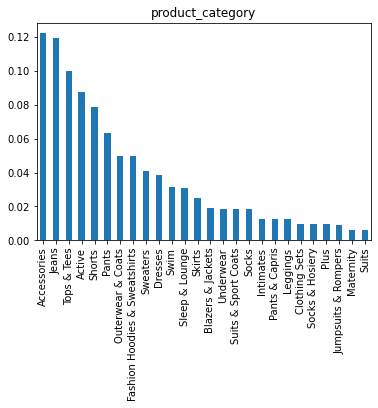

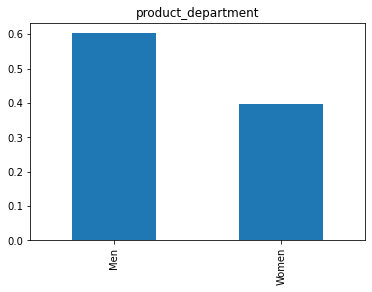

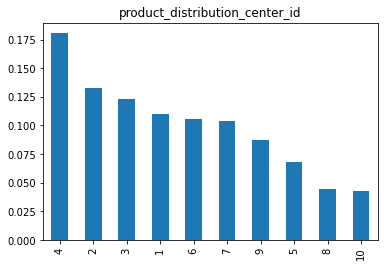

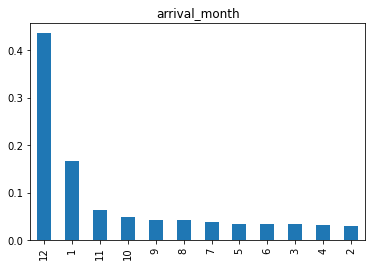

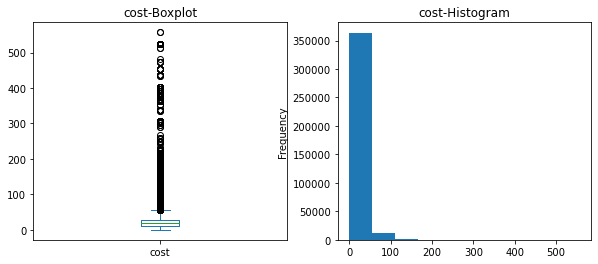

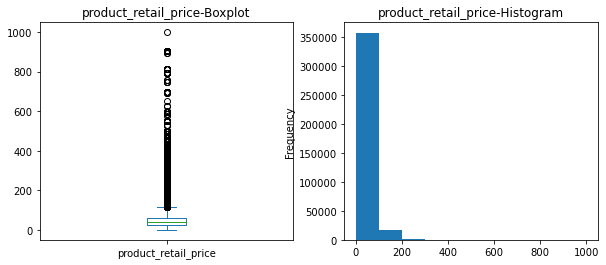

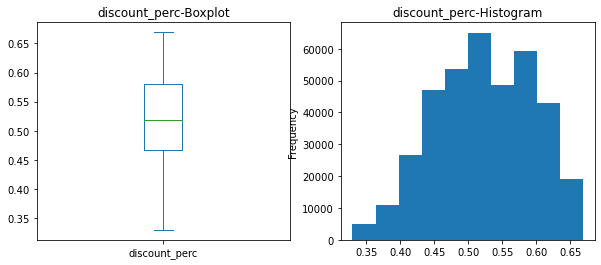

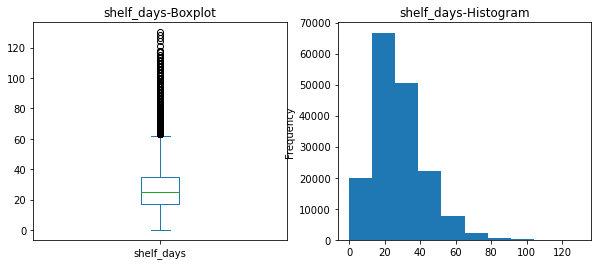

In [16]:
for i in categ_cols :
    df[i].value_counts(normalize=True).plot(kind='bar')
    plt.title(i)
    plt.show()

for i in num_cols :
    _, ax= plt.subplots(1,2,figsize=(10,4))
    df[i].plot(kind='box',ax=ax[0])
    df[i].plot(kind='hist',ax=ax[1])
    ax[0].set_title(i+"-Boxplot")
    ax[1].set_title(i+"-Histogram")
    plt.show()

Most of the fields like discount, department, distribution center-id have a decent dsitribution. For the field `product_category`, there are some categories that don't constitute 2% of the dataset at least. Although there are  outliers noticed for some numerical fields, they are exempted from removing as there can be products that are expensive or belonging to a particular category that doesn't often see many sales. 

## Feature preprocessing
<a name="section-7"></a>

Next, we aggregate the data based on suitable categorical fields in the data and take the average of number of days it took for the product to get sold. For a given `product_id`, there can be multiple item `id`s in this dataset and we want to predict at the product level if that particular product is going to be sold in the next couple of months or not. More accurately describing, we are aggregating the data based on each of the product configurations present in this dataset like the price, cost, category and at which center it is being sold. This way the model can predict *whether a product with so and so properties is going to be sold in the next couple of months or not*.

For the number of days a product got sold in, we will find the average of the `shelf_days` field.

In [15]:
groupby_cols = ['product_id','product_distribution_center_id',
                'product_category', 'product_department',
                'arrival_month',
                'product_retail_price','cost', 'discount_perc']
value_cols = ['shelf_days']


df_prod = df[groupby_cols+value_cols].groupby(by=groupby_cols).mean().reset_index()

Check the aggregated product level data.

In [16]:
df_prod.head()

,product_id,product_distribution_center_id,product_category,product_department,arrival_month,product_retail_price,cost,discount_perc,shelf_days
0,1,1,Tops & Tees,Women,1,49.0,27.048,0.448,NaN
1,3,8,Tops & Tees,Women,12,69.5,41.005,0.410,NaN
2,7,5,Tops & Tees,Women,11,39.5,20.935,0.470,21.0
3,8,3,Tops & Tees,Women,5,168.0,102.312,0.391,19.0
4,9,2,Tops & Tees,Women,2,54.0,27.918,0.483,66.0


Look for null values in the data.

In [17]:
df_prod.isna().sum()/df.shape[0]

product_id                        0.000000
product_distribution_center_id    0.000000
product_category                  0.000000
product_department                0.000000
arrival_month                     0.000000
product_retail_price              0.000000
cost                              0.000000
discount_perc                     0.000000
shelf_days                        0.047537
dtype: float64

Only the `shelf_days` field has null values that correspond to the `product_id`s that have no sold items. 

Plot the distribution of the aggregated `shelf_days` field by generating a box-plot.

<AxesSubplot:>

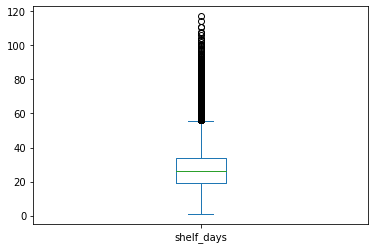

In [18]:
df_prod['shelf_days'].plot(kind='box')

Here, we can see that most of the products are sold within 60 days since they've arrived in the inventory/store. For this tutorial, we will train a machine-learning model that predicts the probability of a product being sold in 60 days.

### Encode the categorical fields
Encode the the `shelf_days` field to generate the target field `sold_in_2mnt` indicitating if the product was sold in 60 days or not.

In [19]:
df_prod['sold_in_2mnt'] = df_prod['shelf_days'].apply(lambda x: 1 if x>=0 and x<60 else 0)
df_prod['sold_in_2mnt'].value_counts(normalize=True)

1    0.73429
0    0.26571
Name: sold_in_2mnt, dtype: float64

Segregate the features into variables for model building.

In [20]:
target = 'sold_in_2mnt'
categ_cols=['product_category','product_department','product_distribution_center_id','arrival_month']
num_cols = ['product_retail_price','cost','discount_perc']

Encode the `product_department` field.

In [21]:
df['product_deprtment']=df['product_department'].apply(lambda x:1 if x=='Women' else 0).value_counts()

Encode the rest of the categorical fields for model building.

In [22]:
# Create dummy variables for each categ. variable
for i in categ_cols:
    ml = pd.get_dummies(df_prod[i], prefix=i+"_", drop_first=True)
    df_new = pd.concat([df_prod, ml], axis=1)

df_new.drop(columns=categ_cols, inplace=True)
df_new.shape

(72440, 17)

### Normalize the numerical fields

Normalize the fields `product_retail_price` and `cost` to the 0-1 scale using Min-Max normalization technique.

In [23]:
scaler= MinMaxScaler()
scaler = scaler.fit(df_new[['product_retail_price','cost']])
df_new[['product_retail_price_norm','cost_norm']]=scaler.transform(df_new[['product_retail_price','cost']])

## Model building
<a name="section-8"></a>

### Train the model
<a name="section-9"></a>

Collect the required fields from the dataframe.

In [24]:
cols=['discount_perc',
       'arrival_month__2', 'arrival_month__3',
       'arrival_month__4', 'arrival_month__5', 'arrival_month__6',
       'arrival_month__7', 'arrival_month__8', 'arrival_month__9',
       'arrival_month__10', 'arrival_month__11', 'arrival_month__12',
       'product_retail_price_norm', 'cost_norm']

Split the data into train(80%) and test(20%) sets.

In [25]:
X = df_new[cols].copy()
y=df_new[target].copy()
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.8, test_size=0.2,random_state=7)

Create the classifier and fit it on the training data.

In [26]:
model = RandomForestClassifier(random_state=7, n_estimators=100)
model.fit(train_X[cols], train_y)

RandomForestClassifier(random_state=7)

### Evaluate the model
<a name="section-10"></a>


Predict on the test set and check the accuracy of the model.

In [27]:
pred_y = model.predict(test_X[cols])

# Calculate the accuracy as our performance metric
accuracy = metrics.accuracy_score(test_y, pred_y)
print("Accuracy: ", accuracy)

Accuracy:  0.8353119823302043


Generate the confusion-matrix on the test set.

In [28]:
confusion = metrics.confusion_matrix(test_y, pred_y)
print(f"Confusion matrix:\n{confusion}")

print(f"\nNormalized confusion matrix:")
for row in confusion:
    print(row / row.sum())

Confusion matrix:
[[2733 1067]
 [1319 9369]]

Normalized confusion matrix:
[0.71921053 0.28078947]
[0.12340943 0.87659057]


The model performance can be stated in terms of specificity(True-negative rate) and sensitivity(True-postivie rate). In the normalized confusion matrix, the top left value represents the True-negative rate and the bottom right value represents the True-positive rate.

## Save the model to a Cloud Storage bucket
<a name="section-11"></a>

Next, save the model to the created Cloud Storage bucket for deployment.

In [44]:
# save the trained model to a local file "model.joblib"
FILE_NAME = "model.joblib"
joblib.dump(model, FILE_NAME)

# Upload the saved model file to Cloud Storage
BLOB_PATH = "inventory_prediction/"
BLOB_NAME = os.path.join(BLOB_PATH, FILE_NAME)

bucket = storage.Client().bucket(BUCKET_NAME)

blob = bucket.blob(BLOB_NAME)
blob.upload_from_filename(FILE_NAME)

## Create a model in Vertex AI
<a name="section-12"></a>

Specify the corresponding model parameters.

In [45]:
MODEL_DISPLAY_NAME = "inventory_prediction_model"
ARTIFACT_GCS_PATH = f"gs://{BUCKET_NAME}/{BLOB_PATH}"


Create a Vertex AI model resource.

In [46]:
from google.cloud import aiplatform

aiplatform.init(project=PROJECT_ID, location=REGION)

model = aiplatform.Model.upload(
    display_name=MODEL_DISPLAY_NAME,
    artifact_uri=ARTIFACT_GCS_PATH,
    serving_container_image_uri="us-docker.pkg.dev/vertex-ai/prediction/sklearn-cpu.1-0:latest",
)

model.wait()

print(model.display_name)
print(model.resource_name)

INFO:google.cloud.aiplatform.models:Creating Model
INFO:google.cloud.aiplatform.models:Create Model backing LRO: projects/931647533046/locations/us-central1/models/6686196179203522560/operations/1368099297416970240
INFO:google.cloud.aiplatform.models:Model created. Resource name: projects/931647533046/locations/us-central1/models/6686196179203522560
INFO:google.cloud.aiplatform.models:To use this Model in another session:
INFO:google.cloud.aiplatform.models:model = aiplatform.Model('projects/931647533046/locations/us-central1/models/6686196179203522560')
inventory_prediction_model
projects/931647533046/locations/us-central1/models/6686196179203522560


## Create an Endpoint
<a name="section-13"></a>

Set the display name for the endpoint.

In [47]:
ENDPOINT_DISPLAY_NAME = "inventory_prediction_endpoint"

Create an endpoint resource on Vertex AI.

In [48]:
endpoint = aiplatform.Endpoint.create(display_name=ENDPOINT_DISPLAY_NAME)

print(endpoint.display_name)
print(endpoint.resource_name)

INFO:google.cloud.aiplatform.models:Creating Endpoint
INFO:google.cloud.aiplatform.models:Create Endpoint backing LRO: projects/931647533046/locations/us-central1/endpoints/4695363251347652608/operations/6893453090247147520
INFO:google.cloud.aiplatform.models:Endpoint created. Resource name: projects/931647533046/locations/us-central1/endpoints/4695363251347652608
INFO:google.cloud.aiplatform.models:To use this Endpoint in another session:
INFO:google.cloud.aiplatform.models:endpoint = aiplatform.Endpoint('projects/931647533046/locations/us-central1/endpoints/4695363251347652608')
inventory_prediction_endpoint
projects/931647533046/locations/us-central1/endpoints/4695363251347652608


## Deploy the model to the created Endpoint
<a name="section-14"></a>

Configure the deployment name, machine type, and other parameters for the deployment.

In [49]:
DEPLOYED_MODEL_NAME = "inventory_prediction_deployment"
MACHINE_TYPE = "n1-standard-2"

Deploy the model to the created endpoint.

In [50]:
model.deploy(
    endpoint=endpoint,
    deployed_model_display_name=DEPLOYED_MODEL_NAME,
    machine_type=MACHINE_TYPE,
)

model.wait()

print("Model display-name - ",model.display_name)
print("Model resource-name - ",model.resource_name)
endpoint.list_models()

INFO:google.cloud.aiplatform.models:Deploying model to Endpoint : projects/931647533046/locations/us-central1/endpoints/4695363251347652608
INFO:google.cloud.aiplatform.models:Deploy Endpoint model backing LRO: projects/931647533046/locations/us-central1/endpoints/4695363251347652608/operations/4348919300782817280
INFO:google.cloud.aiplatform.models:Endpoint model deployed. Resource name: projects/931647533046/locations/us-central1/endpoints/4695363251347652608
inventory_prediction_model
projects/931647533046/locations/us-central1/models/6686196179203522560


Note the `DEPLOYED_MODEL_ID` for deleting the deployment during clean up.

In [55]:
DEPLOYED_MODEL_ID = ""

## What-If Tool
<a name="section-15"></a>

The What-If Tool can be used to analyze the model predictions on test data. See a brief introduction to the [What-If Tool](https://pair-code.github.io/what-if-tool/get-started/). In this tutorial, the What-If Tool will be configured and run on the model deployed on Vertex AI Endpoints in the previous steps.

WitConfigBuilder provides the set_ai_platform_model() method to configure the What-If Tool with a model deployed as a version on Ai Platform models. This feature currently supports only Ai Platform but not Vertex AI models. Fortunately, there is also an option to pass a custom function for generating predictions through the set_custom_predict_fn() method where either the locally trained model or a function that returns predictions from a Vertex AI model can be passed.

### Prepare test samples
Save some samples from the test data for both the available classes (Fraud/not-Fraud) to analyze the model using the What-If Tool.

In [34]:
# collect some samples for each class-label from the test data
sample_size = 200
pos_samples = test_y[test_y == 1].sample(sample_size).index
neg_samples = test_y[test_y == 0].sample(sample_size).index
test_samples_y = pd.concat([test_y.loc[pos_samples], test_y.loc[neg_samples]])
test_samples_X = test_X.loc[test_samples_y.index].copy()

## Running the What-If Tool on the deployed Vertex AI model

Define a function to fetch the predictions from the deployed model and run it on the created test data configuring the What-If tool.

In [36]:
# configure the target and class-labels
TARGET_FEATURE = target
LABEL_VOCAB = ["not-sold", "sold"]

# function to return predictions from the deployed Model
def endpoint_predict_sample(instances: list):
    prediction = endpoint.predict(instances=instances)
    preds = [[1 - i, i] for i in prediction.predictions]
    return preds


# Combine the features and labels into one array for the What-If Tool
test_examples = np.hstack(
    (test_samples_X.to_numpy(), test_samples_y.to_numpy().reshape(-1, 1))
)

# Configure the WIT with the prediction function
config_builder = (
    WitConfigBuilder(
        test_examples.tolist(), test_samples_X.columns.tolist() + [target]
    )
    .set_custom_predict_fn(endpoint_predict_sample)
    .set_target_feature(TARGET_FEATURE)
    .set_label_vocab(LABEL_VOCAB)
)

# run the WIT-widget
WitWidget(config_builder, height=800)

WitWidget(config={'model_type': 'classification', 'label_vocab': ['not-sold', 'sold'], 'feature_names': ['disc…

### Understanding the What-If tool

In the **Datapoint editor** tab, you can highlight a dot in the result set and ask the What If tool to pick the "nearest counterfactual". This is a row of data closest to the row of data you selected but with the opposite outcome. Features in the left-hand table are editable and can show what tweaks are needed to get a particular row of data to flip from one outcome to another. For example, altering the *discount_percentage* feature would show how it impacts the prediction. 

<img src="images/Datapoint_editor.png">

Under the **Performance & Fairness** tab, you can slice the prediction results by a second variable. This allows digging deeper and understanding how different segments of the data react to the model's predictions.  For example, in the following image, the higher the *discount_percentage*, the lesser the false negatives and the lower the *discount_percentage*, the higher the false positives. 

<img src="images/Performance_and_fairness.png">

The **Features** tab in the end provides you an intuitive and interactive way to understand the features present in the data. Similar to the exploratory data analysis steps performed in this notebook, What-If tool provides a visual and statistical description on the features.

<img src="images/features.PNG">

## Clean up
<a name="section-16"></a>

To clean up all Google Cloud resources used in this project, you can delete the Google Cloud project you used for the tutorial.

Otherwise, you can delete the individual resources you created in this tutorial:

Undeploy the model.

In [56]:
endpoint.undeploy(deployed_model_id=DEPLOYED_MODEL_ID)

INFO:google.cloud.aiplatform.models:Undeploying Endpoint model: projects/931647533046/locations/us-central1/endpoints/4695363251347652608
INFO:google.cloud.aiplatform.models:Undeploy Endpoint model backing LRO: projects/931647533046/locations/us-central1/endpoints/4695363251347652608/operations/6821395496209219584
INFO:google.cloud.aiplatform.models:Endpoint model undeployed. Resource name: projects/931647533046/locations/us-central1/endpoints/4695363251347652608


Delete the endpoint.

In [57]:
endpoint.delete()

INFO:google.cloud.aiplatform.base:Deleting Endpoint : projects/931647533046/locations/us-central1/endpoints/4695363251347652608
INFO:google.cloud.aiplatform.base:Delete Endpoint  backing LRO: projects/931647533046/locations/us-central1/operations/619938809320046592
INFO:google.cloud.aiplatform.base:Endpoint deleted. . Resource name: projects/931647533046/locations/us-central1/endpoints/4695363251347652608


Delete the model.

In [58]:
model.delete()

INFO:google.cloud.aiplatform.base:Deleting Model : projects/931647533046/locations/us-central1/models/6686196179203522560
INFO:google.cloud.aiplatform.base:Delete Model  backing LRO: projects/931647533046/locations/us-central1/operations/5627941594956038144
INFO:google.cloud.aiplatform.base:Model deleted. . Resource name: projects/931647533046/locations/us-central1/models/6686196179203522560


Remove the contents of the Cloud Storage bucket.

In [59]:
! gsutil -m rm -r $BUCKET_URI